[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mjwen/chee6397/blob/main/lab/lab5-intro_pytorch.ipynb)

# Lab 5: Intro to automatic differentiation and PyTorch  

This notebook is intended to introduce:
- the basic ideas of automatic differentiation and how to use it in PyTorch;
- the basic ideas of PyTorch and how to use it to train a simple MLP.

## Installation

Follow the instructions on the [PyTorch website](https://pytorch.org/get-started/locally/) to install PyTorch. 
We will only use the CPU version in this lab, so you can ignore the CUDA related options.

## PyTorch basics

### PyTorch can be used as a replacement of Numpy

In [1]:
import numpy as np
import torch

In [2]:
M1 = np.array([[1., 2., 3.], [4., 5., 6.]])
M1

array([[1., 2., 3.],
       [4., 5., 6.]])

In [3]:
M1.shape

(2, 3)

In [4]:
v1 = np.array([1., 2., 3.]).reshape(3, 1)

v1

array([[1.],
       [2.],
       [3.]])

In [5]:
M1@v1

array([[14.],
       [32.]])

In [6]:
M2 = torch.tensor([[1., 2., 3.], [4., 5., 6.]])
M2

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [7]:
M2.shape


torch.Size([2, 3])

In [8]:
v2 = torch.tensor([1., 2., 3.]).reshape(3, 1)

M2@v2

tensor([[14.],
        [32.]])

### Converting between numpy and torch

In [9]:
torch.from_numpy(M1)

tensor([[1., 2., 3.],
        [4., 5., 6.]], dtype=torch.float64)

In [10]:
M2.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

## Automatic differentiation with PyTorch

We will use the following simple example to illustrate the basic ideas of automatic differentiation.

$L = (y - wx)^2$

$\frac{\partial L}{\partial w} = 2(y - wx)(-x)$

$\frac{\partial L}{\partial x} = 2(y - wx)(-w)$

In [11]:
x = torch.tensor([1., 2., 3.])
w = torch.tensor([4., 5., 6.], requires_grad=True)
y = torch.zeros(3)

In [12]:
diff =  y - w*x
diff

tensor([ -4., -10., -18.], grad_fn=<SubBackward0>)

In [13]:
square = diff**2
square

tensor([ 16., 100., 324.], grad_fn=<PowBackward0>)

In [14]:
L = torch.sum(square)
L

tensor(440., grad_fn=<SumBackward0>)

Get the gradient of L with respect to w

In [15]:
# dw = torch.autograd.grad(L, w)

# dw

Cannot get grad of L with respect to x (because x does not require grad)

In [16]:
# dx = torch.autograd.grad(L, x)

### Alternative way to get grad instead of calling autograd.grad

Note:
- this is the recommended way to get the gradient.
- cannot backpropagate a second time. So comment out the above dw cells to run the below.

In [17]:
L.backward()


In [18]:
w.grad

tensor([  8.,  40., 108.])

In [19]:
print(x.grad)

None


### You can even get higher order derivatives 

In [20]:
def get_loss(w):
    x = torch.tensor([1., 2., 3.])
    y = torch.zeros(3)

    L = torch.sum((y - w*x)**2)

    return L

Get the Hessian 

In [21]:
from torch.autograd.functional import hessian

w = torch.tensor([4., 5., 6.], requires_grad=True)

hessian(get_loss, w)

tensor([[ 2.,  0.,  0.],
        [ 0.,  8.,  0.],
        [ 0.,  0., 18.]])

## MLP with PyTorch 

In [22]:
import torch.nn as nn

class MyTwoLayerMLP(nn.Module):

    def __init__(self, num_input_nodes, num_hidden_nodes, num_out_nodes):
        super().__init__()

        self.num_hidden_nodes = num_hidden_nodes
        self.num_out_nodes = num_out_nodes

        self.linear1 = nn.Linear(num_input_nodes, num_hidden_nodes)
        self.linear2 = nn.Linear(num_hidden_nodes, num_out_nodes)



    def forward(self, X):

        h = self.linear1(X)
        h = torch.relu(h)
        y = self.linear2(h)

        return y

### Let's create some data to test our model

In [23]:
torch.manual_seed(0)  # random seed

def generate_data(N, num_in=3):
    """Generate some random data with num_in=3 features x1, x2, x3.
    The target is y = x1^2 + x2^2 + x3^2.

    Args:
        N: number of samples
        num_in: number of input features
    """
    X = torch.randn(N, num_in)
    y = torch.square(X).sum(dim=1).reshape(N, 1)

    return X, y


In [24]:
X, y = generate_data(N= 100)

In [25]:
X.shape

torch.Size([100, 3])

In [26]:
y.shape

torch.Size([100, 1])

### Create a model with 10 hidden nodes

In [27]:
num_hidden = 10
num_out  = 1

model = MyTwoLayerMLP(num_in, num_hidden, num_out)

NameError: name 'num_in' is not defined

Let's check that the model works 

In [ ]:
y_pred = model(X)

y_pred.shape


torch.Size([100, 1])

### Train the model 

In [ ]:
def train_one_step(model, optimizer, X, y):
    """Performs one step of gradient descent on the given model.

    Args:
        model: the model to train
        optimizer: the optimizer to use
        X: the input data
        y: the target data
    """
    y_pred = model(X)
    loss = torch.mean((y_pred - y)**2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [ ]:
### Using SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
num_steps = 30

losses = []
for s in range(num_steps):
    for X_i, y_i in zip(X, y):
        l = train_one_step(model, optimizer, X_i, y_i)
        losses.append(l.item())

Text(0, 0.5, 'loss')

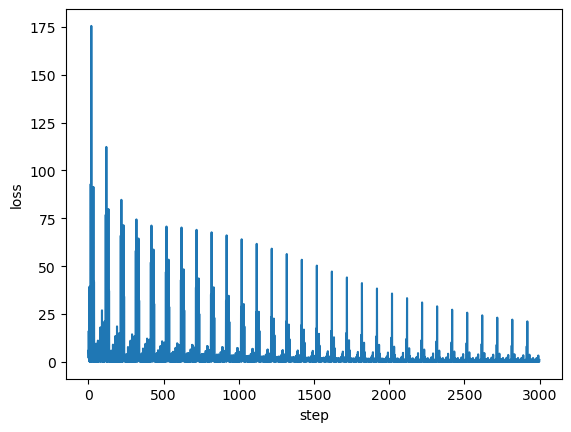

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(losses)

ax.set_xlabel('step')
ax.set_ylabel('loss')